# --- START ---

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from tqdm.notebook import tqdm
import cv2
import os
import glob
import gc
from IPython.display import display
sns.set()

# カリフォルニア住宅価格
カテゴリがなさそう

In [ ]:
# https://qiita.com/nuco_fn/items/75272b5f4a3c27da132a

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# California Housingデータセットをロード
data = fetch_california_housing()

# 特徴量と目的変数をDataFrameに変換
df = pd.DataFrame(data.data, columns=data.feature_names)
df[data.target_names[0]] = data.target
# display(df)

feature_names = {
    'MedInc': 'ブロックの所得中央値',
    'HouseAge': 'ブロックの家屋年齢の中央値',
    'AveRooms': '平均部屋数',
    'AveBedrms': '平均寝室数',
    'Population': 'ブロックの人口',
    'AveOccup': '世帯人数の平均値',
    'Latitude': '緯度',
    'Longitude': '経度',
    'MedHouseVal': '住宅価格',
}
df = df.rename(columns=feature_names)

# 結果を表示
display(df)

,ブロックの所得中央値,ブロックの家屋年齢の中央値,平均部屋数,平均寝室数,ブロックの人口,世帯人数の平均値,緯度,経度,住宅価格
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
from tensorflow.keras.datasets import boston_housing
import pandas as pd

# ボストン住宅価格データセットをダウンロードする
(features, target), _ = boston_housing.load_data()

# 特徴量名を設定する
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# 特徴量と目的変数を結合してDataFrameを作成する
df = pd.DataFrame(features, columns=feature_names)
df['PRICE'] = target

display(df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20,19.4
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59,25.2
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83,19.4
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79,19.4


## アウトライン

In [ ]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# データセットを読み込む
california_housing = fetch_california_housing()

# 特徴量をDataFrameに変換する
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
display(df)

# 目的変数を追加する
df["target"] = california_housing.target

# 探索的データ分析
display(df.describe())

# 欠損値の処理は不要

# 外れ値の処理
df = df[(df["MedInc"] < 10) & (df["HouseAge"] < 50) & (df["AveRooms"] < 10) & (df["AveBedrms"] < 2)]

# 特徴量と目的変数に分ける
X = df.drop("target", axis=1)
y = df["target"]

# スケーリングする
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 対数変換
y = np.log(y)

# データを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルを学習する
model = LinearRegression()
model.fit(X_train, y_train)

# テストデータで評価する
y_pred = model.predict(X_test)

# 予測値を元のスケールに戻す
y_pred = np.exp(y_pred)

# 評価指標を計算する
mae = mean_absolute_error(np.exp(y_test), y_pred)
mse = mean_squared_error(np.exp(y_test), y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(np.square((np.exp(y_test) - y_pred) / np.exp(y_test)))) * 100

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("RMSPE:", rmspe)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


MAE: 0.4691761540504979
MSE: 0.4559878121542194
RMSE: 0.6752686962641016
RMSPE: 36.376864776708125


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
target,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

<Axes: xlabel='target', ylabel='Count'>

<Axes: xlabel='target', ylabel='Count'>

MAE:  0.14684463589809438
MSE:  0.036951078266546374
RMSE:  0.19222663256309303
RMSPE:  27.630840285532315


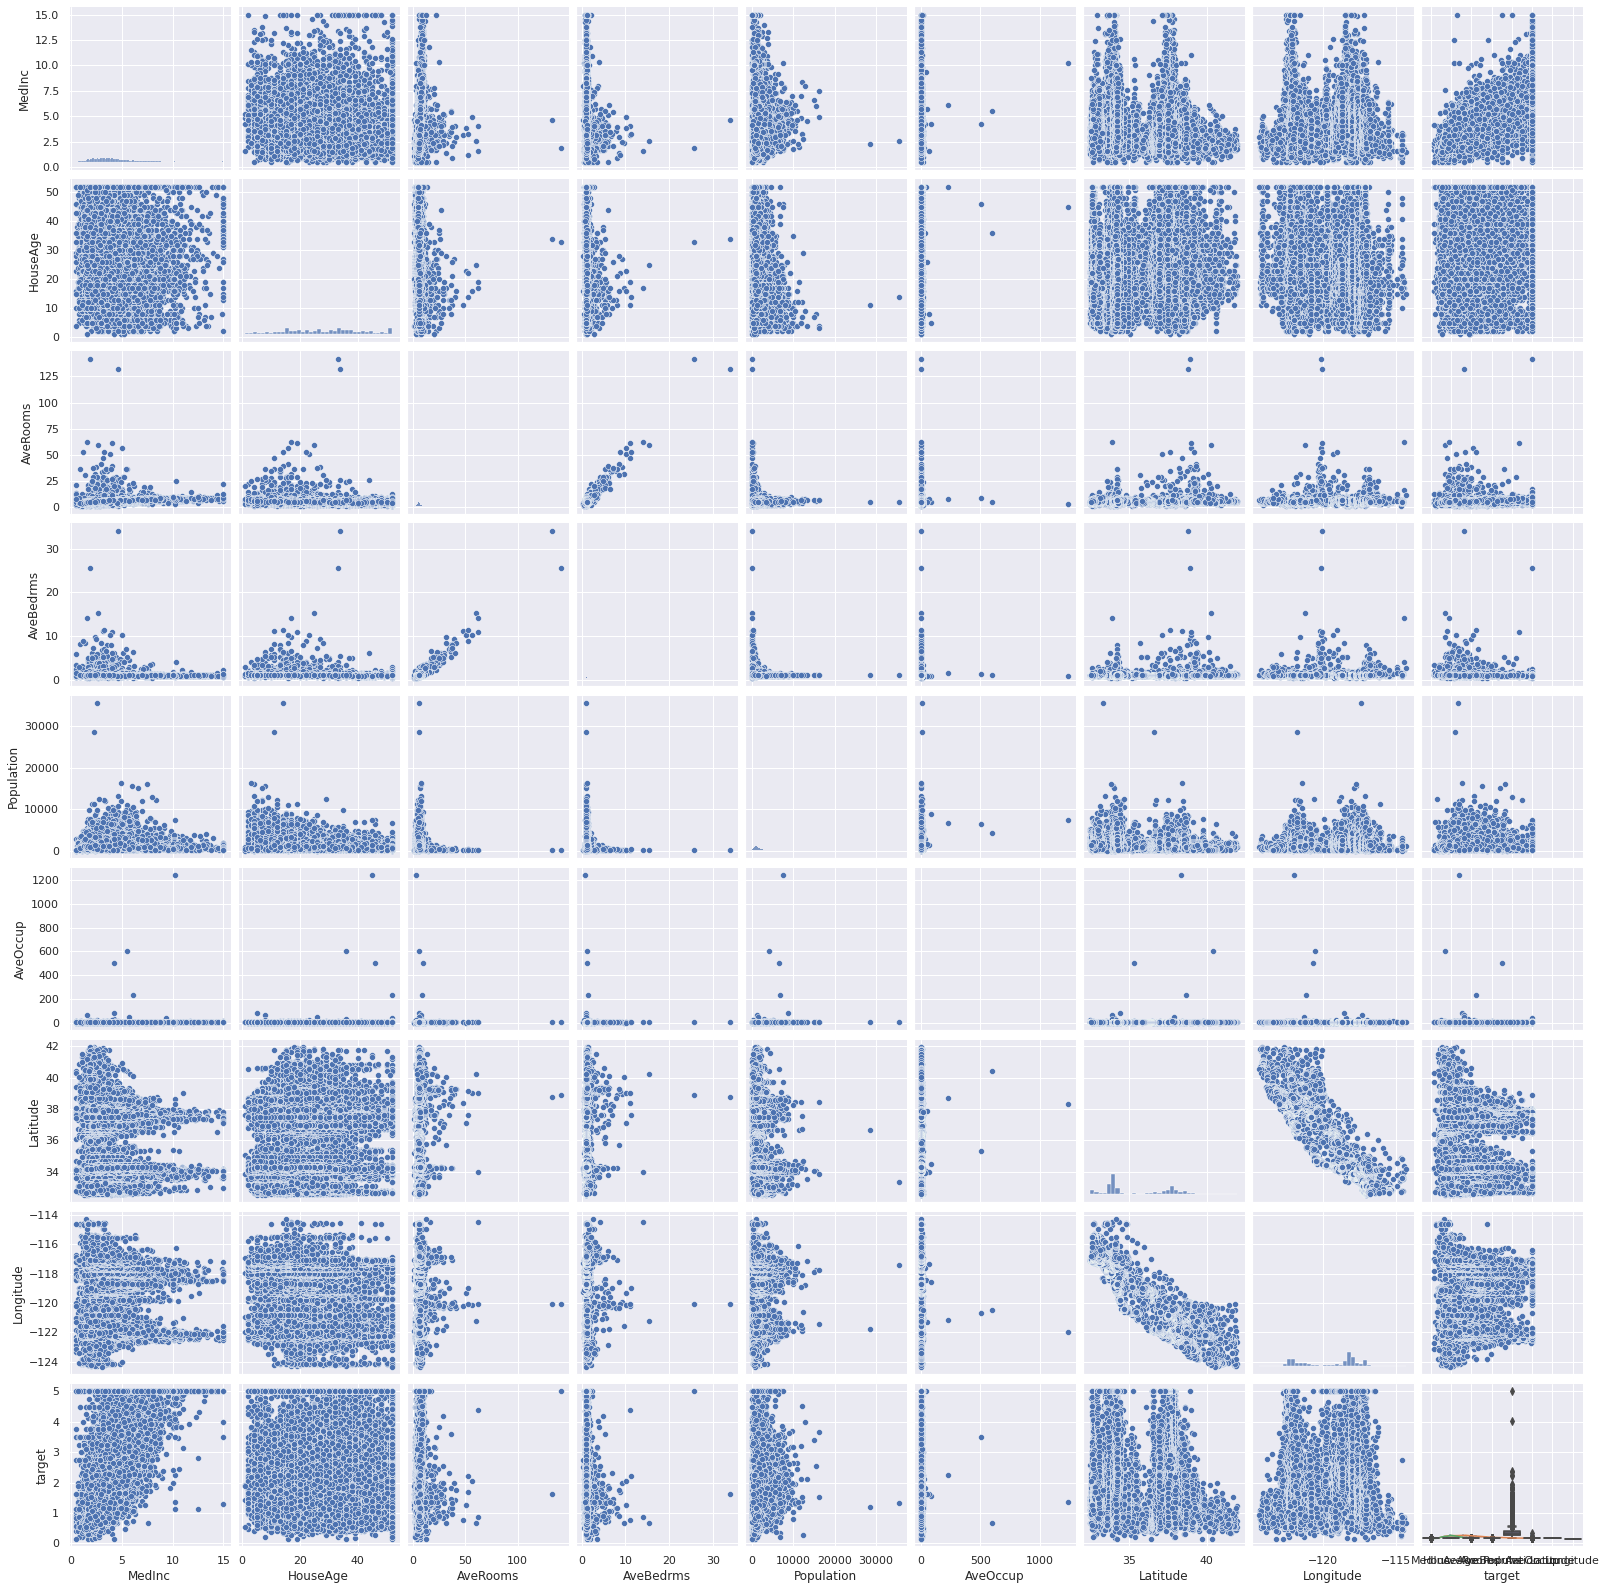

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# データセットの読み込み
california_housing = fetch_california_housing(as_frame=True)

# DataFrameに変換
df = california_housing.data
df['target'] = california_housing.target

# 探索的データ分析
display(df.head())
display(df.describe())
display(df.corr())
sns.pairplot(df)

# 欠損処理
display(df.isnull().sum())
# 欠損値がないことが確認できたため、欠損処理は不要

# 外れ値処理
before_outliers = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
display(sns.boxplot(data=df[before_outliers]))
q1 = df[before_outliers].quantile(0.25)
q3 = df[before_outliers].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
for col in before_outliers:
    df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]
after_outliers = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
display(sns.boxplot(data=df[after_outliers]))

# スケーリングする
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, :-1])
df_scaled = pd.DataFrame(df_scaled, columns=california_housing.feature_names)

# 目的変数の対数変換
sns.histplot(df['target'], kde=True)
df['target'] = np.log1p(df['target'])
sns.histplot(df['target'], kde=True)

# データ分割(Hold Out)
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['target'], test_size=0.3, random_state=42)

# 学習する
model = LinearRegression()
model.fit(X_train, y_train)

# 評価する
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100
print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("RMSPE: ", rmspe)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


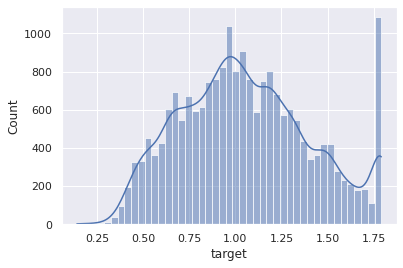

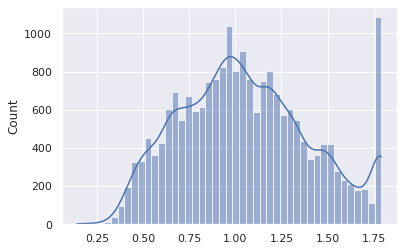

MAE: 0.16787331370533362
MSE: 0.05034011172872021
RMSE: 0.224366021778522
RMSPE: 30.18309489731938


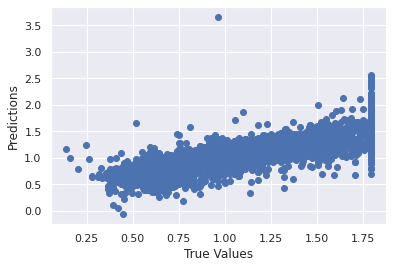

In [ ]:
# 以下をPythonで実装して

# ・scikit-learnのカリフォルニア住宅価格データセットを読み込む
# ・DataFrameにする
# ・探索的データ分析
# ・欠損処理
# ・外れ値処理(処理した特徴量に関しては、処理前と処理後の分布をseabornで可視化)
# ・スケーリングする
# ・目的変数の対数変換(変換前と変換後の分布をseabornで可視化)
# ・データ分割(Hold Out)
# ・学習する
# ・評価する(MAE, MSE, RMSE, RMSPE)
# ・テストデータに関する正解と予測結果の散布図を描画

# ※DataFrameやSeriesはprint()ではなくdisplay()で表示する
# ※seedを固定して結果に再現性があるようにする


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# カリフォルニア住宅価格データセットを読み込む
dataset = fetch_california_housing()

# DataFrameにする
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

# 探索的データ分析
display(df.head())
display(df.describe())
# sns.pairplot(df)

# 欠損処理 (欠損値はないため省略)

# # 外れ値処理 (GrLivAreaとTotalBsmtSFに対して外れ値処理を行う)
# sns.histplot(df['GrLivArea'], kde=True)
# plt.show()
# sns.histplot(df['TotalBsmtSF'], kde=True)
# plt.show()
# df = df[(df['GrLivArea'] < 4500) & (df['TotalBsmtSF'] < 3000)]
# sns.histplot(df['GrLivArea'], kde=True)
# plt.show()
# sns.histplot(df['TotalBsmtSF'], kde=True)
# plt.show()

# スケーリング
scaler = StandardScaler()
df[dataset.feature_names] = scaler.fit_transform(df[dataset.feature_names])

# 目的変数の対数変換
df['target'] = np.log1p(df['target'])

# 変換前と変換後の分布をseabornで可視化
sns.histplot(df['target'], kde=True)
plt.show()
sns.histplot(np.log1p(dataset.target), kde=True)
plt.show()

# データ分割(Hold Out)
X_train, X_test, y_train, y_test = train_test_split(df[dataset.feature_names], df['target'], test_size=0.2, random_state=42)

# 学習する
lr = LinearRegression()
lr.fit(X_train, y_train)

# 評価する
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test))) * 100

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('RMSPE:', rmspe)

# テストデータに関する正解と予測結果の散布図を描画
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64

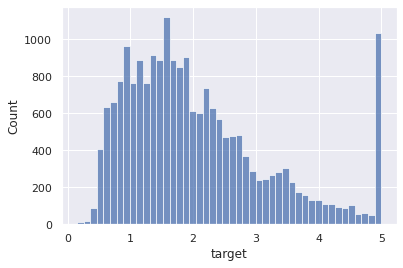

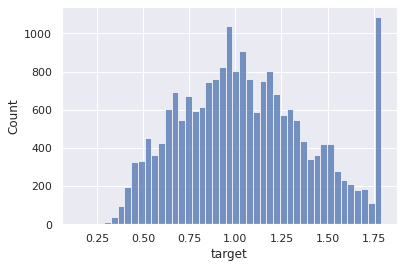

MAE: 0.168
MSE: 0.050
RMSE: 0.224
RMSPE: 60.345


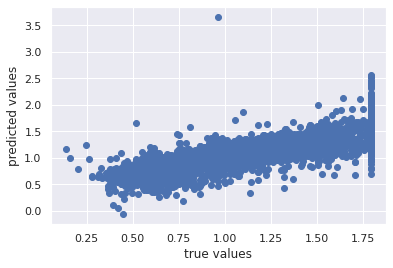

In [ ]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# データセットの読み込み
california = fetch_california_housing()

# 特徴量のDataFrameの作成
X = pd.DataFrame(california.data, columns=california.feature_names)

# 目的変数のSeriesの作成
y = pd.Series(california.target, name='target')

# 探索的データ分析
display(X.head())
display(X.describe())
display(y.describe())
sns.histplot(y)
plt.show()

# 欠損処理
X.isnull().sum()

# # 外れ値処理
# sns.boxplot(data=X[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']])
# plt.show()

# # 外れ値の除去（1%以下、99%以上の値を除去）
# percentiles = X.quantile([0.01, 0.99])
# X = X[(X > percentiles.loc[0.01]) & (X < percentiles.loc[0.99])]
# sns.boxplot(data=X[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']])
# plt.show()

# スケーリング
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 目的変数の対数変換
y = np.log1p(y)
sns.histplot(y)
plt.show()

# データ分割(Hold Out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 線形回帰モデルの学習
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 評価
y_pred = lin_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(np.square((np.expm1(y_test) - np.expm1(y_pred)) / np.expm1(y_test)))) * 100
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RMSPE: {rmspe:.3f}")

# テストデータに関する正解と予測結果の散布図を描画
plt.scatter(y_test, y_pred)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.show()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


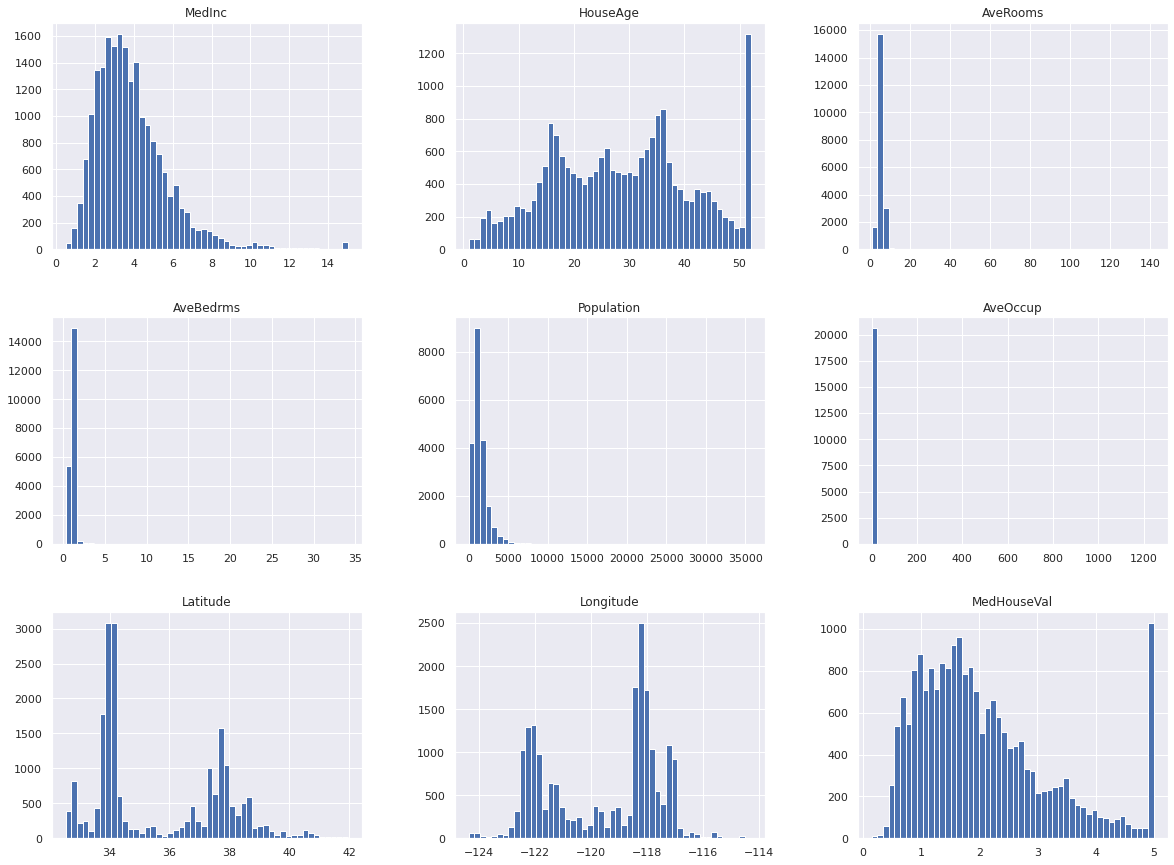

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

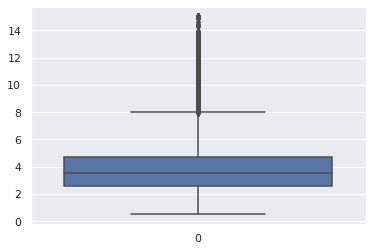

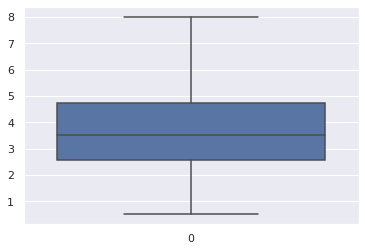

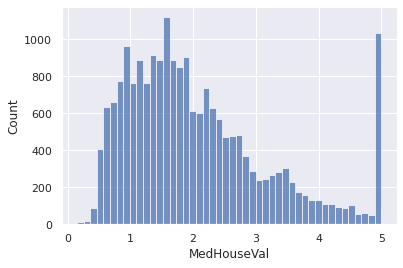

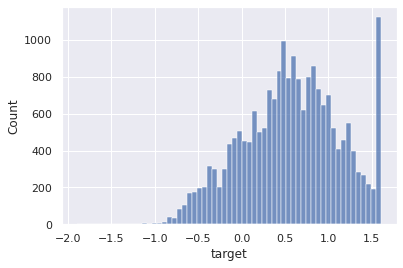

MAE: 0.260
MSE: 0.117
RMSE: 0.342
RMSPE: 43.046


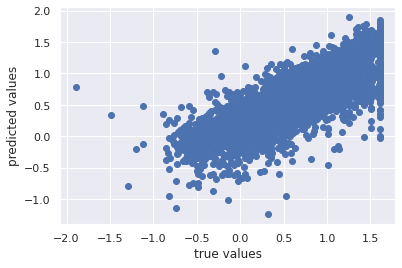

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# データセットの読み込み
california = fetch_california_housing(as_frame=True)
df = california.frame

# DataFrameの表示
display(df.head())

# 記述統計量の表示
display(df.describe())

# ヒストグラムの表示
df.hist(bins=50, figsize=(20,15))
plt.show()

# 欠損値の確認
display(df.isnull().sum())

# 外れ値処理
def remove_outlier(df, column):
    # IQRを求める
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # 上限値と下限値を求める
    upper = q3 + iqr * 1.5
    lower = q1 - iqr * 1.5
    # 上限値より大きい値は上限値に置換する
    df[column] = np.where(df[column] > upper, upper, df[column])
    # 下限値より小さい値は下限値に置換する
    df[column] = np.where(df[column] < lower, lower, df[column])
    return df

# 外れ値処理前の分布を可視化
sns.boxplot(df['MedInc'])
plt.show()

# 外れ値処理
df = remove_outlier(df, 'MedInc')

# 外れ値処理後の分布を可視化
sns.boxplot(df['MedInc'])
plt.show()

# スケーリング
from sklearn.preprocessing import StandardScaler

# 目的変数の対数変換
df['target'] = np.log(df['MedHouseVal'])
# 変換前の分布を可視化
sns.histplot(df['MedHouseVal'])
plt.show()
# 変換後の分布を可視化
sns.histplot(df['target'])
plt.show()

# 説明変数と目的変数に分割
X = df.drop(['MedHouseVal', 'target'], axis=1)
y = df['target']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 学習
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 評価指標の算出
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmspe = np.sqrt(np.mean(np.square((np.exp(y_test) - np.exp(y_pred)) / np.exp(y_test)))) * 100

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"RMSPE: {rmspe:.3f}")

# テストデータに関する正解と予測結果の散布図を描画
plt.scatter(y_test, y_pred)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.show()


# ボストン住宅価格
ボストン住宅価格データはポリティカルにヤバいため、scikit-learnでも取り扱わないことになったようです。

# クレジットカードの与信判定

In [ ]:
# 「Credit Approval Data Set」はクレジットカードの与信判定を行うためのデータセットです。以下はPythonで機械学習するためのコード例です。

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# データセットを読み込みます。
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
headers = ["A" + str(i) for i in range(1, 17)]
df = pd.read_csv(url, header=None, names=headers)
display(df)

# データセットには欠損値や文字列が含まれているため、前処理が必要です。まず、欠損値を "?" で置き換えます。
# (欠損値を "?" で表現しているため、前処理で欠損値を適切に処理する必要があります。)
df = df.replace('?', np.nan)

# 次に、各列のデータ型を確認して、文字列型の列をラベルエンコーディングします。
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

# 最後に、特徴量とターゲット変数を分離し、トレーニングセットとテストセットに分割します。
X = df.drop("A16", axis=1)
y = df["A16"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# トレーニングセットを使って決定木モデルをトレーニングし、テストセットを使って予測精度を評価します。
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# A1: 申請者の性別（文字列）
# A2: 申請者の年齢（数値）
# A3: 申請者の婚姻状況（文字列）
# A4: 申請者の学歴（文字列）
# A5: 申請者の職業（文字列）
# A6: 申請者の年収（数値）
# A7: 申請者が所有する不動産の価値（数値）
# A8: 申請者が借りたクレジットの額（数値）
# A9: 申請者の返済期間（数値）
# A10: 申請者が借りたクレジットの目的（文字列）
# A11: 申請者が保有する自動車の有無（文字列）
# A12: 申請者が保証人を有するかどうか（文字列）
# A13: 保証人の情報（数値）
# A14: 申請者の現在の仕事の長さ（数値）
# A15: 申請者が持つ貯蓄や債務の情報（数値）
# A16: 申請者がクレジットを受け取ることができるかどうか（クラスラベル、0または1）

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


Accuracy: 0.7608695652173914


In [ ]:
# データセットをダウンロード
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
col_names = ['A' + str(i) for i in range(1,17)]
df = pd.read_csv(url, header=None, names=col_names)

# ? を NaN に置き換え
df = df.replace('?', np.nan)

# 特徴量名をリネーム
feature_names = {
    'A1': 'gender',
    'A2': 'age',
    'A3': 'debt',
    'A4': 'married',
    'A5': 'bank_customer',
    'A6': 'education_level',
    'A7': 'ethnicity',
    'A8': 'years_employed',
    'A9': 'prior_default',
    'A10': 'employed',
    'A11': 'credit_score',
    'A12': 'drivers_license',
    'A13': 'citizen',
    'A14': 'zip_code',
    'A15': 'income',
    'A16': 'approved'
}
df = df.rename(columns=feature_names)
display(df)

,gender,age,debt,married,bank_customer,education_level,ethnicity,years_employed,prior_default,employed,credit_score,drivers_license,citizen,zip_code,income,approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


# クレジットカードの貸し倒れ

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


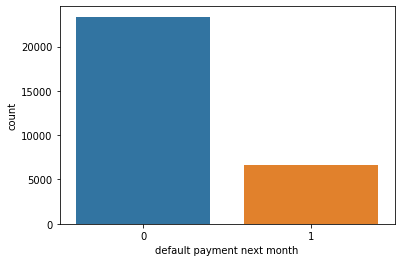

Accuracy: 0.816
Confusion Matrix:
 [[4414  273]
 [ 831  482]]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# データのダウンロード
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url, header=1, index_col=0)
display(df)

#//$//
sns.countplot(x=df['default payment next month'])
plt.show()
#//$//

# データの前処理
# 目的変数と説明変数を分ける
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# データのスケーリング
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 機械学習モデルの作成
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# モデルの評価
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = classifier.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


# ID：個人を特定するためのID
# LIMIT_BAL：与信枠（借入限度額）
# SEX：性別（1=男性、2=女性）
# EDUCATION：教育レベル（1=卒業、2=大学修士課程、3=博士課程、4=その他、5=不明、6=無職）
# MARRIAGE：婚姻状況（1=既婚、2=独身、3=その他）
# AGE：年齢
# PAY_0～PAY_6：過去の6か月間における返済状況（-1=返済完了、0=滞納なし、1=1か月滞納、2=2か月滞納、...、8=8か月滞納以上）
# BILL_AMT1～BILL_AMT6：請求書の金額（過去6か月分）
# PAY_AMT1～PAY_AMT6：前回の支払い金額（過去6か月分）
# default.payment.next.month：クレジットカードの債務不履行（1=債務不履行、0=履行）

# 銀行のマーケティングキャンペーンに参加するかどうか

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

--2023-03-29 11:57:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   561KB/s    in 0.8s    

2023-03-29 11:57:27 (561 KB/s) - ‘bank-additional.zip’ saved [444572/444572]



In [ ]:
!unzip bank-additional.zip

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
!ls bank-additional/*

bank-additional/bank-additional.csv
bank-additional/bank-additional-full.csv
bank-additional/bank-additional-names.txt


In [ ]:
!head bank-additional/bank-additional.csv

"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"
30;"blue-collar";"married";"basic.9y";"no";"yes";"no";"cellular";"may";"fri";487;2;999;0;"nonexistent";-1.8;92.893;-46.2;1.313;5099.1;"no"
39;"services";"single";"high.school";"no";"no";"no";"telephone";"may";"fri";346;4;999;0;"nonexistent";1.1;93.994;-36.4;4.855;5191;"no"
25;"services";"married";"high.school";"no";"yes";"no";"telephone";"jun";"wed";227;1;999;0;"nonexistent";1.4;94.465;-41.8;4.962;5228.1;"no"
38;"services";"married";"basic.9y";"no";"unknown";"unknown";"telephone";"jun";"fri";17;3;999;0;"nonexistent";1.4;94.465;-41.8;4.959;5228.1;"no"
47;"admin.";"married";"university.degree";"no";"yes";"no";"cellular";"nov";"mon";58;1;999;0;"nonexistent";-0.1;93.2;-42;4.191;5195.8;"no"
32;"services";"single";"university.degree";"no";"no";"no";"cellular";"sep";"thu";1

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Titanicデータセットを読み込む
df = sns.load_dataset("titanic")

# Survived列の値ごとにデータ数をカウント
counts = df['survived'].value_counts()

# 少ない方のデータ数に合わせてダウンサンプリングを行う
df_majority = df[df['survived']==0]
df_minority = df[df['survived']==1]
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # オーバーサンプリングではないのでFalse
                                   n_samples=counts[1], # 少ない方のデータ数に合わせる
                                   random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# 結果を表示
print(df_downsampled['survived'].value_counts())

0    342
1    342
Name: survived, dtype: int64


In [ ]:
counts

0    549
1    342
Name: survived, dtype: int64

In [ ]:
# Bank Marketing Data Set
# UCI Machine Learning Repository で公開されているデータセット
# ポルトガルの銀行が行ったマーケティングキャンペーンに関するデータセット
# 銀行のマーケティングキャンペーンに参加するかどうかを予測するクラス分類タスク

# 「Bank Marketing Data Set」とは、ポルトガルの銀行が行ったマーケティングキャンペーンに関するデータセットです。このキャンペーンは、電話で銀行の商品やサービスを提供することで行われました。
# このデータセットには、銀行が収集した情報が含まれています。例えば、顧客の年齢、職業、教育水準、家族構成、前回のキャンペーンでの反応などが含まれています。また、銀行が提供する商品やサービスに対する興味の度合い、キャンペーンに対する反応、最終的な口座開設の有無などの情報も含まれています。
# このデータセットは、機械学習アルゴリズムの開発やテストに使用されることがあります。例えば、銀行がどのような顧客に対してマーケティングを行えば効果的かを分析するために使用されることがあります。また、キャンペーンの成功率を予測するために使用されることもあります。

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


#//$//

# データをダウンロードして読み込む
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
df = pd.read_csv('bank-additional/bank-additional.csv', sep=';')
display(df)


#//$// 少ない方のデータ数に合わせてダウンサンプリングを行う
counts = df['y'].value_counts()
df_majority = df[df['y']=='no']
df_minority = df[df['y']=='yes']
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # オーバーサンプリングではないのでFalse
                                   n_samples=counts[1], # 少ない方のデータ数に合わせる
                                   random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# display(df_downsampled)

df = df_downsampled.copy()
df.reset_index(inplace=True, drop=True)

#//$//



#//$// 特徴量選択

# age: 顧客の年齢（数値）
# job: 顧客の職業（カテゴリ変数）
# marital: 顧客の婚姻状況（カテゴリ変数）
# education: 顧客の教育水準（カテゴリ変数）
# default: 顧客がデフォルトしたかどうか（カテゴリ変数）
# balance: 顧客の口座残高（数値）                                   #//$// なさそう#//$//
# housing: 顧客が住宅ローンを持っているかどうか（カテゴリ変数）
# loan: 顧客が個人ローンを持っているかどうか（カテゴリ変数）
# contact: 連絡方法（カテゴリ変数）
# day: 最後に顧客に連絡した日にち（数値）
# month: 最後に顧客に連絡した月（カテゴリ変数）
# duration: 最後の連絡の通話時間（秒数）
# campaign: 今回のキャンペーンで顧客に連絡した回数（数値）
# pdays: 最後のキャンペーン以前に顧客に連絡した日数（数値）
# previous: 最後のキャンペーン以前に顧客に連絡した回数（数値）
# poutcome: 最後のキャンペーンの結果（カテゴリ変数）
# y: 顧客が定期預金を申し込んだかどうか（目的変数、カテゴリ変数）

features_X = ['age','job','marital', 'education', 'housing', 'loan', 'contact', 'duration']

#//$//




# 特徴量と目的変数を準備する
# X = df.iloc[:, :-1]
X = df[features_X]
y = df.iloc[:, -1]

# カテゴリ変数を数値に変換する
le = LabelEncoder()
X = X.apply(le.fit_transform)


#//$//
dict_mapping = {'no':0, 'yes':1}
y = y.map(dict_mapping)
#//$//


# 訓練用とテスト用にデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# display(X_train)
# display(X_test)
# display(y_train)
# display(y_test)

# モデルを作成して学習する
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# テスト用データで予測して評価する
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,528,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no


Accuracy: 0.7624309392265194
F1 score: 0.7817258883248731


In [ ]:
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,9,0,2,3,0,2,0,1,7,1,158,0,5,1,2,5,24,0,103,0
1,12,1,1,2,1,0,0,0,3,2,188,0,14,0,1,8,16,5,174,9
2,16,9,1,4,0,2,0,0,1,1,22,0,14,0,1,8,12,16,176,9
3,18,0,2,5,0,0,0,1,6,3,141,0,14,0,1,7,17,15,158,7
4,10,2,0,1,0,0,2,0,6,2,106,0,14,1,0,3,7,4,120,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,51,5,1,5,0,2,2,0,1,4,180,2,14,0,1,2,0,21,61,5
898,57,5,1,0,0,2,0,0,8,4,399,0,14,2,0,5,23,2,91,0
899,40,0,1,5,0,2,0,0,6,1,549,1,14,0,1,3,7,4,123,6
900,27,4,1,5,0,2,0,0,9,1,247,0,2,2,2,0,1,23,45,3


In [ ]:
print(list(df.columns))
print(list(df.select_dtypes(include='number').columns))
print(list(df.select_dtypes(exclude='number').columns))

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


<Axes: xlabel='y', ylabel='count'>

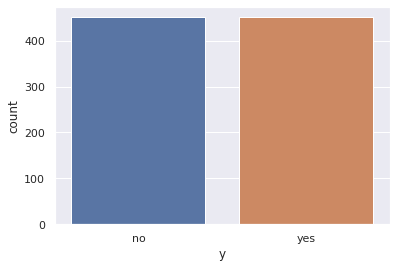

In [ ]:
sns.countplot(x=df['y'])

<Axes: xlabel='default', ylabel='count'>

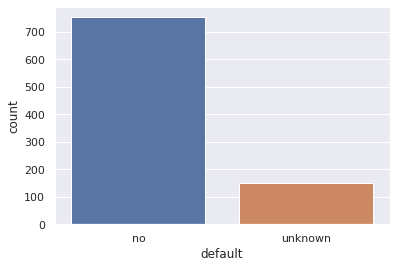

In [ ]:
sns.countplot(x=df['default'])
# ダウンサンプリングしたら'yes'がなくなった

<Axes: xlabel='y', ylabel='count'>

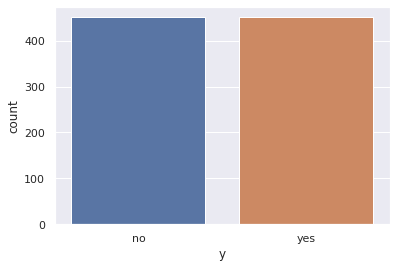

In [ ]:
sns.countplot(x=df['y'])

# タイタニック

## アウトライン by CGPT

,sex,age,sibsp,fare,class,embark_town,alive
sex,1.000000,0.099037,-0.106296,-0.182457,0.150826,0.109639,-0.536762
age,0.099037,1.000000,-0.307351,0.093143,-0.365902,-0.032565,-0.082446
sibsp,-0.106296,-0.307351,1.000000,0.139860,0.065187,0.033064,-0.015523
fare,-0.182457,0.093143,0.139860,1.000000,-0.552893,-0.283510,0.266100
class,0.150826,-0.365902,0.065187,-0.552893,1.000000,0.244145,-0.356462
embark_town,0.109639,-0.032565,0.033064,-0.283510,0.244145,1.000000,-0.181979
alive,-0.536762,-0.082446,-0.015523,0.266100,-0.356462,-0.181979,1.000000


Logistic Regression
Accuracy: 0.776
F1 Score: 0.714

Random Forest
Accuracy: 0.757
F1 Score: 0.711


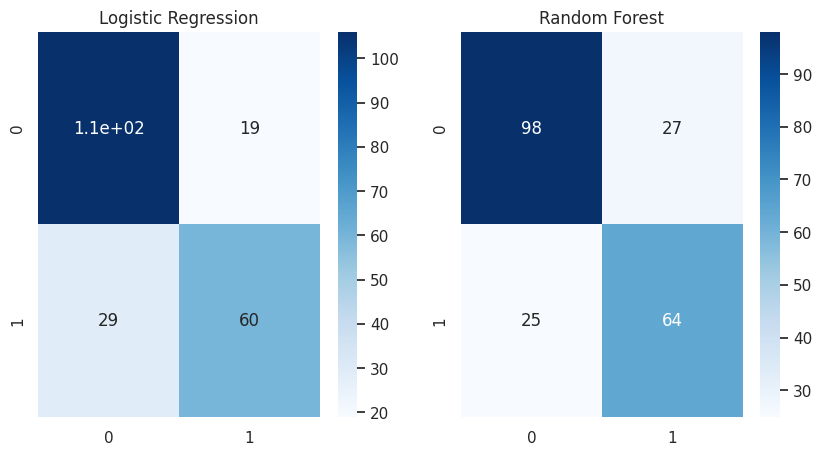

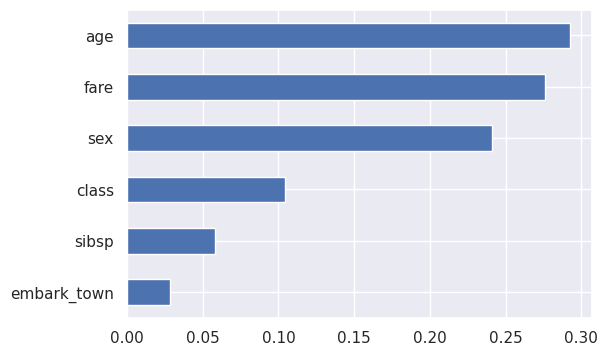

In [54]:
# 以下のPythonコードを教えて

# ・seabornからtitanicデータセットを読み込む
# ・カラムを ['sex', 'age', 'sibsp', 'fare', 'class', 'embark_town', 'alive'] に絞る
# ・欠損値処理
# ・カテゴリ変数を数値化
# ・特徴量のスケーリング
# ・相関行列を表示
# ・訓練データとテストデータに分割
# ・ロジスティック回帰で学習
# ・ランダムフォレストで学習
# ・AccuracyとF1を表示
# ・Confusion Matrixを描画(ラベル付きで)
# ・特徴量重要度を描画

# ※DataFrameやSeriesはprint()ではなくdisplay()で表示する
# ※seedを固定して結果に再現性があるようにする


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データの読み込み
titanic = sns.load_dataset('titanic')

# カラムを絞る
titanic = titanic[['sex', 'age', 'sibsp', 'fare', 'class', 'embark_town', 'alive']]

# 欠損値処理
titanic = titanic.dropna()

# カテゴリ変数を数値化
cat_cols = ['sex', 'class', 'embark_town', 'alive']
for col in cat_cols:
    le = LabelEncoder()
    titanic[col] = le.fit_transform(titanic[col])

# 特徴量のスケーリング
scaler = StandardScaler()
titanic[['age', 'sibsp', 'fare']] = scaler.fit_transform(titanic[['age', 'sibsp', 'fare']])

# 相関行列を表示
display(titanic.corr())

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(titanic.drop('alive', axis=1), titanic['alive'], test_size=0.3, random_state=0)

# ロジスティック回帰で学習
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

# ランダムフォレストで学習
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# AccuracyとF1を表示
print('Logistic Regression')
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print(f'Accuracy: {acc_lr:.3f}')
print(f'F1 Score: {f1_lr:.3f}')

print('\nRandom Forest')
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f'Accuracy: {acc_rf:.3f}')
print(f'F1 Score: {f1_rf:.3f}')

# Confusion Matrixを描画
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap='Blues', ax=ax[1])
ax[1].set_title('Random Forest')
plt.show()

# 特徴量重要度を描画
plt.figure(figsize=(6, 4))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

## 特徴量検討

In [ ]:
df = sns.load_dataset("titanic")
display(df)

# lst_columns = ['sex', 'age', 'sibsp', 'fare', 'class', 'embark_town', 'alive']
# df = df[lst_columns]
# display(df)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


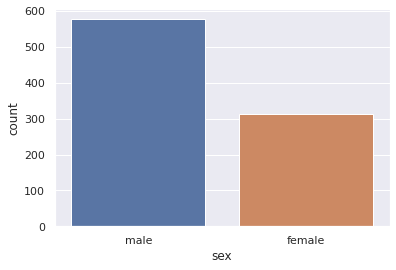

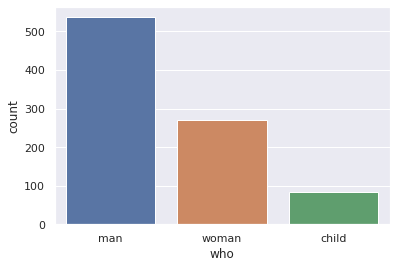

In [ ]:
sns.countplot(x=df['sex'])
plt.show()
sns.countplot(x=df['who'])
plt.show()

<Axes: xlabel='embark_town', ylabel='count'>

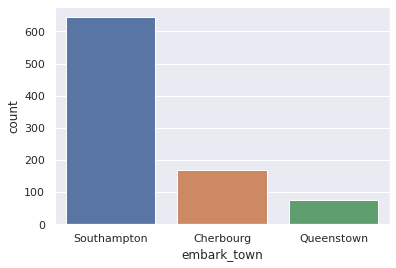

In [ ]:
sns.countplot(x=df['embark_town'])

<Axes: xlabel='sibsp', ylabel='count'>

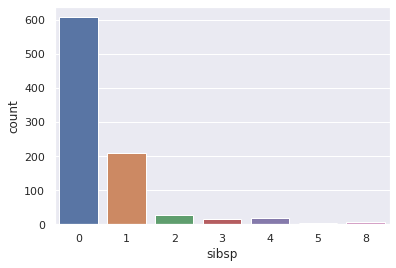

In [ ]:
sns.countplot(x=df['sibsp'])

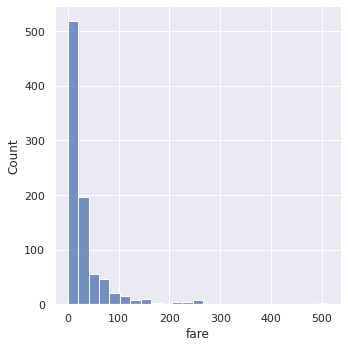

In [ ]:
# sns.displot(df['fare'])
sns.displot(df['fare'], bins=25)

<Axes: >

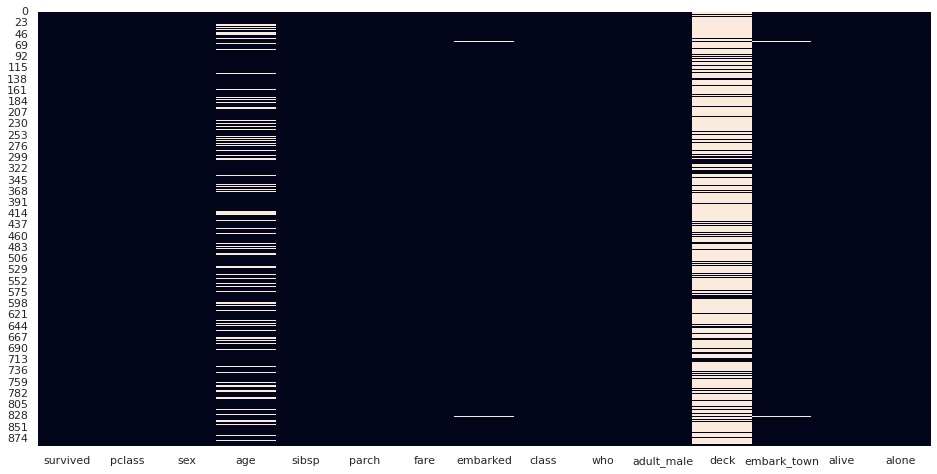

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(), cbar=False)

# 本番

## データ準備

In [2]:
# データセットを読み込む
df = sns.load_dataset('titanic')

# 使用するカラムを抽出する
cols_to_use = ['sex', 'age', 'sibsp', 'fare', 'class', 'embark_town', 'alive'] # 'sex'+'age'
df = df[cols_to_use]
display(df)

,sex,age,sibsp,fare,class,embark_town,alive
0,male,22.0,1,7.2500,Third,Southampton,no
1,female,38.0,1,71.2833,First,Cherbourg,yes
2,female,26.0,0,7.9250,Third,Southampton,yes
3,female,35.0,1,53.1000,First,Southampton,yes
4,male,35.0,0,8.0500,Third,Southampton,no
...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,Southampton,no
887,female,19.0,0,30.0000,First,Southampton,yes
888,female,NaN,1,23.4500,Third,Southampton,no
889,male,26.0,0,30.0000,First,Cherbourg,yes


## 基本統計量確認

In [3]:
df.describe()

,age,sibsp,fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208
std,14.526497,1.102743,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,1.000000,31.000000
max,80.000000,8.000000,512.329200


In [4]:
# 数値変数
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
# カテゴリ変数
df.describe(exclude='number').T

,count,unique,top,freq
sex,891,2,male,577
class,891,3,Third,491
embark_town,889,3,Southampton,644
alive,891,2,no,549


## 可視化

<Axes: xlabel='sex', ylabel='count'>

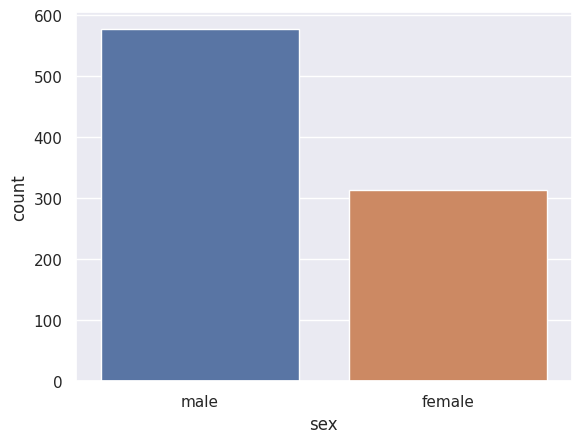

In [6]:
sns.countplot(x=df['sex'])

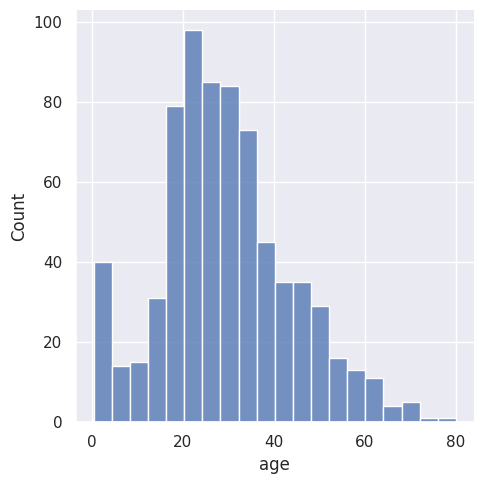

In [7]:
sns.displot(df['age'])

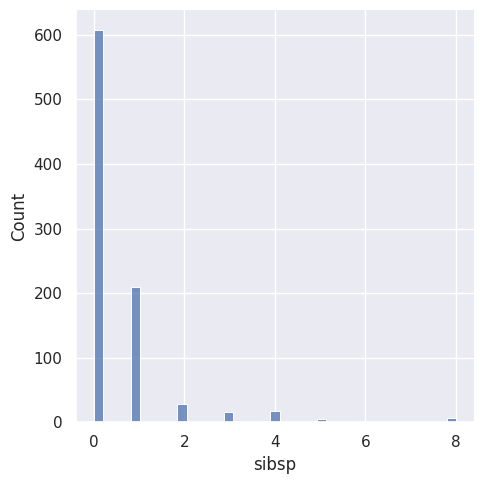

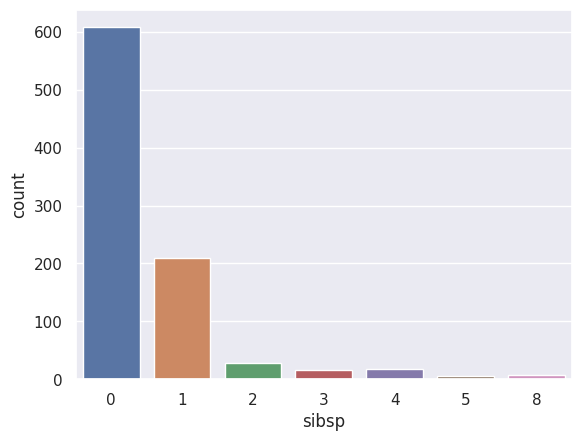

In [8]:
sns.displot(df['sibsp'])
plt.show()
sns.countplot(x=df['sibsp'])
plt.show()

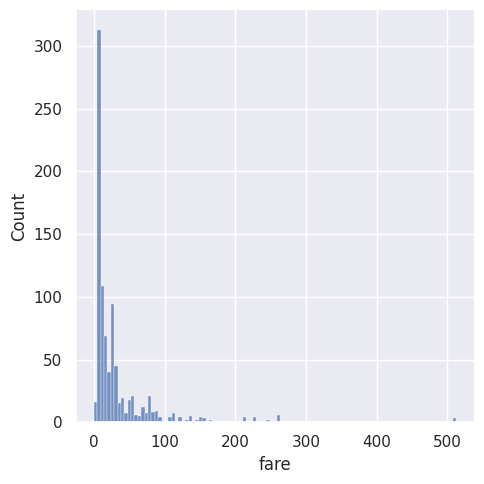

In [9]:
sns.displot(df['fare'])

<Axes: xlabel='class', ylabel='count'>

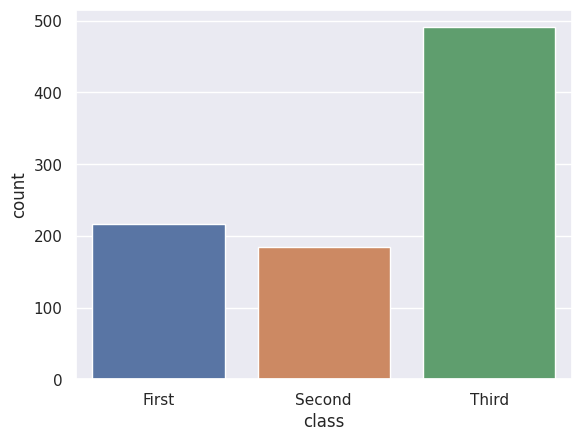

In [10]:
sns.countplot(x=df['class'])

<Axes: xlabel='embark_town', ylabel='count'>

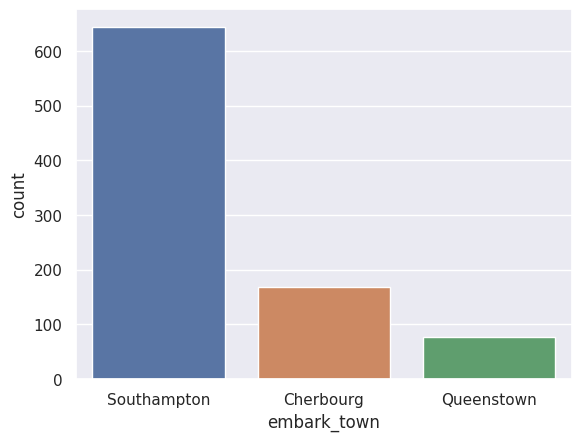

In [11]:
sns.countplot(x=df['embark_town'])

<Axes: xlabel='alive', ylabel='count'>

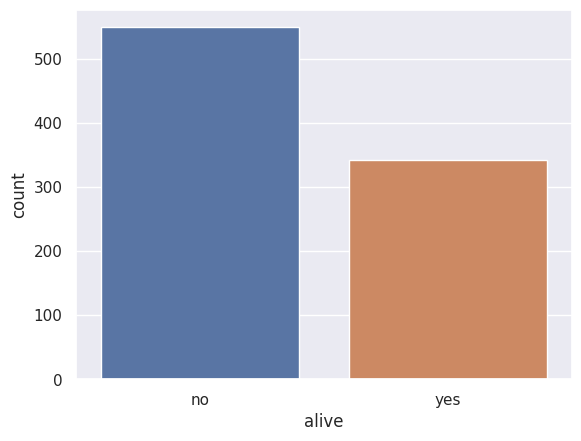

In [12]:
sns.countplot(x=df['alive'])

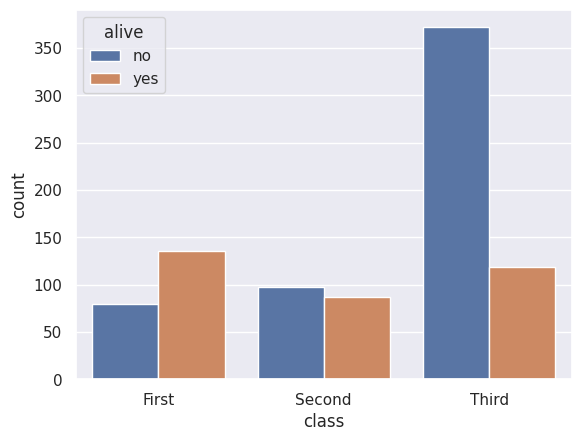

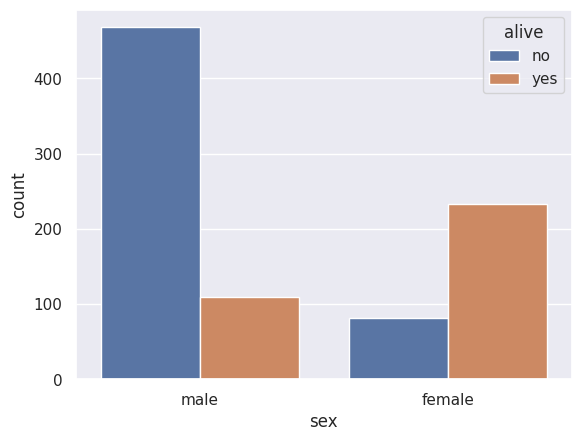

In [13]:
sns.countplot(x=df['class'], hue=df['alive'])
plt.show()
sns.countplot(x=df['sex'], hue=df['alive'])
plt.show()

## 欠損値処理

### 確認

<Axes: >

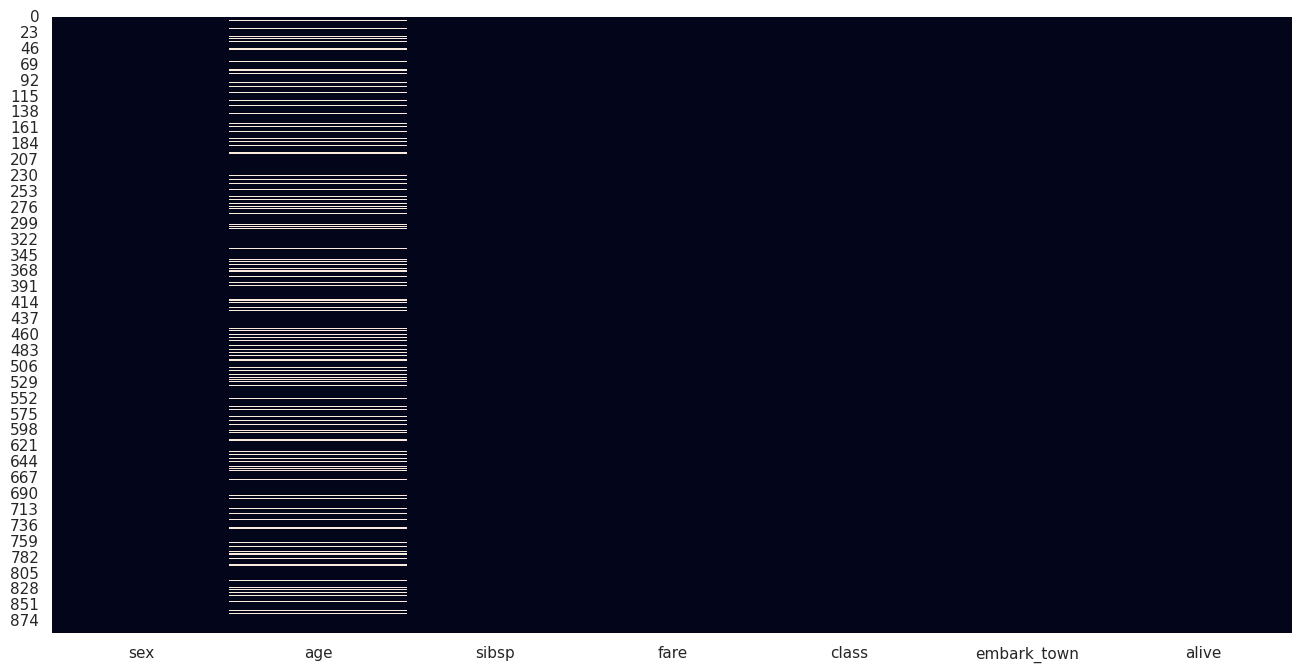

In [14]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(), cbar=False)

In [15]:
df.isnull().sum()

sex              0
age            177
sibsp            0
fare             0
class            0
embark_town      2
alive            0
dtype: int64

In [16]:
def kesson_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : 'NaN', 1 : '%'})
        return kesson_table_ren_columns
 
kesson_table(df)

,NaN,%
sex,0,0.000000
age,177,19.865320
sibsp,0,0.000000
fare,0,0.000000
class,0,0.000000
embark_town,2,0.224467
alive,0,0.000000


### embark_town

In [17]:
df.shape

(891, 7)

In [18]:
# embark_townが欠損しているレコードを削除
df.dropna(subset=['embark_town'], inplace=True)

In [19]:
df.shape

(889, 7)

### age

In [20]:
# ageの欠損値を中央値を算出
age_median = df['age'].median()
print('ageの中央値', age_median)

# 中央値で補完
df['age'].fillna(age_median, inplace=True)

ageの中央値 28.0


### 再確認

In [21]:
kesson_table(df)

,NaN,%
sex,0,0.0
age,0,0.0
sibsp,0,0.0
fare,0,0.0
class,0,0.0
embark_town,0,0.0
alive,0,0.0


### 外れ値の除去

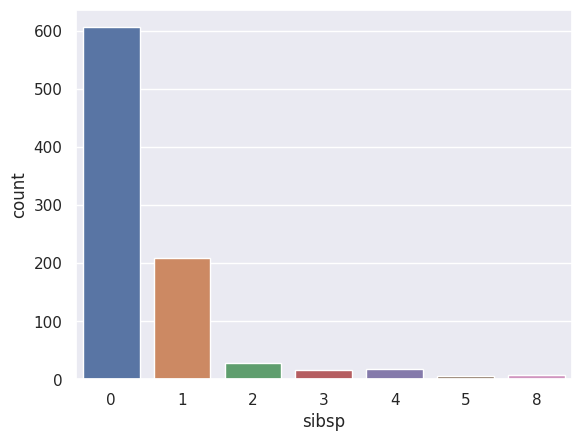

In [56]:
sns.countplot(x=df['sibsp'])
plt.show()

## カテゴリの数値化

### 確認

In [22]:
display(df)
display(df.info())

,sex,age,sibsp,fare,class,embark_town,alive
0,male,22.0,1,7.2500,Third,Southampton,no
1,female,38.0,1,71.2833,First,Cherbourg,yes
2,female,26.0,0,7.9250,Third,Southampton,yes
3,female,35.0,1,53.1000,First,Southampton,yes
4,male,35.0,0,8.0500,Third,Southampton,no
...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,Southampton,no
887,female,19.0,0,30.0000,First,Southampton,yes
888,female,28.0,1,23.4500,Third,Southampton,no
889,male,26.0,0,30.0000,First,Cherbourg,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          889 non-null    object  
 1   age          889 non-null    float64 
 2   sibsp        889 non-null    int64   
 3   fare         889 non-null    float64 
 4   class        889 non-null    category
 5   embark_town  889 non-null    object  
 6   alive        889 non-null    object  
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 49.6+ KB


None

### sex

In [23]:
df['sex'].value_counts()

male      577
female    312
Name: sex, dtype: int64

In [24]:
dict_mapping = {'male':0, 'female':1}
df['sex'] = df['sex'].map(dict_mapping)

In [25]:
df['sex'].value_counts()

0    577
1    312
Name: sex, dtype: int64

### class

In [26]:
df['class'].value_counts()

Third     491
First     214
Second    184
Name: class, dtype: int64

In [27]:
dict_mapping = {'First':1, 'Second':2, 'Third':3}
df['class'] = df['class'].map(dict_mapping)

In [28]:
df['class'].value_counts()

3    491
1    214
2    184
Name: class, dtype: int64

### embark_town

In [29]:
# label encoding は、カテゴリ変数を数値に変換するだけで簡単で、特にカテゴリに順序関係がある場合に有用です。たとえば、 embarked 列には、 C > Q > S という順序があると考えることができます。
# この場合、 label encoding を使用すると、データがより整理され、予測性能が向上する可能性があります。

# 一方、 one-hot encoding は、各カテゴリ値に対して新しい列を作成するため、カテゴリ変数の影響を均等に扱います。この方法は、カテゴリに順序関係がない場合に最適です。
# しかし、多くのカテゴリ値がある場合は、列数が急激に増加し、過剰適合の問題が発生する可能性があります。

In [30]:
# df['embark_town'].value_counts()
display(df)

,sex,age,sibsp,fare,class,embark_town,alive
0,0,22.0,1,7.2500,3,Southampton,no
1,1,38.0,1,71.2833,1,Cherbourg,yes
2,1,26.0,0,7.9250,3,Southampton,yes
3,1,35.0,1,53.1000,1,Southampton,yes
4,0,35.0,0,8.0500,3,Southampton,no
...,...,...,...,...,...,...,...
886,0,27.0,0,13.0000,2,Southampton,no
887,1,19.0,0,30.0000,1,Southampton,yes
888,1,28.0,1,23.4500,3,Southampton,no
889,0,26.0,0,30.0000,1,Cherbourg,yes


In [31]:
# one-hotエンコーディングする
embarked_one_hot = pd.get_dummies(df['embark_town'], prefix='embark')
df = pd.concat([df, embarked_one_hot], axis=1)
df

,sex,age,sibsp,fare,class,embark_town,alive,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,22.0,1,7.2500,3,Southampton,no,0,0,1
1,1,38.0,1,71.2833,1,Cherbourg,yes,1,0,0
2,1,26.0,0,7.9250,3,Southampton,yes,0,0,1
3,1,35.0,1,53.1000,1,Southampton,yes,0,0,1
4,0,35.0,0,8.0500,3,Southampton,no,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,13.0000,2,Southampton,no,0,0,1
887,1,19.0,0,30.0000,1,Southampton,yes,0,0,1
888,1,28.0,1,23.4500,3,Southampton,no,0,0,1
889,0,26.0,0,30.0000,1,Cherbourg,yes,1,0,0


In [32]:
# 不要な列を削除する
df = df.drop(['embark_town'], axis=1)
df

,sex,age,sibsp,fare,class,alive,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,22.0,1,7.2500,3,no,0,0,1
1,1,38.0,1,71.2833,1,yes,1,0,0
2,1,26.0,0,7.9250,3,yes,0,0,1
3,1,35.0,1,53.1000,1,yes,0,0,1
4,0,35.0,0,8.0500,3,no,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,13.0000,2,no,0,0,1
887,1,19.0,0,30.0000,1,yes,0,0,1
888,1,28.0,1,23.4500,3,no,0,0,1
889,0,26.0,0,30.0000,1,yes,1,0,0


### alive

In [33]:
df['alive'].value_counts()

no     549
yes    340
Name: alive, dtype: int64

In [35]:
# sklearnのLabelEncoderクラスをインポート
from sklearn.preprocessing import LabelEncoder

# インスタンス生成
le = LabelEncoder()

# alive列にfit_transform()を適用して、エンコードする
le.fit(df['alive'])
df['alive'] = le.transform(df['alive'])

In [36]:
df['alive'].value_counts()

0    549
1    340
Name: alive, dtype: int64

### 再確認

In [37]:
display(df)

,sex,age,sibsp,fare,class,alive,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,22.0,1,7.2500,3,0,0,0,1
1,1,38.0,1,71.2833,1,1,1,0,0
2,1,26.0,0,7.9250,3,1,0,0,1
3,1,35.0,1,53.1000,1,1,0,0,1
4,0,35.0,0,8.0500,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,13.0000,2,0,0,0,1
887,1,19.0,0,30.0000,1,1,0,0,1
888,1,28.0,1,23.4500,3,0,0,0,1
889,0,26.0,0,30.0000,1,1,1,0,0


## 特徴量スケーリング

In [ ]:
# titanic データセットに含まれる特徴量をスケーリングする必要があるかどうかは、使用する機械学習アルゴリズムによって異なります。
# 例えば、線形回帰やロジスティック回帰などのアルゴリズムは、特徴量がスケーリングされている方がより良い性能を発揮することがあります。
# 一方、決定木やランダムフォレストなどのアルゴリズムは、特徴量のスケーリングに敏感ではありません。

# したがって、titanic データセットを使用する場合、最初に使用する機械学習アルゴリズムについて調べ、そのアルゴリズムが特徴量のスケーリングに敏感であるかどうかを確認する必要があります。
# もしアルゴリズムがスケーリングに敏感である場合は、特徴量をスケーリングすることを検討する必要があります。

# また、特徴量をスケーリングする場合、一般的には標準化（平均0、分散1にする方法）または正規化（最小値0、最大値1にする方法）のいずれかを使用します。

In [55]:
df.describe()

,sex,age,sibsp,fare,alive,embark_Cherbourg,embark_Queenstown,embark_Southampton
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.350956,29.315152,0.524184,32.096681,0.382452,0.188976,0.086614,0.724409
std,0.477538,12.984932,1.103705,49.697504,0.486260,0.391710,0.281427,0.447063
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,14.454200,0.000000,0.000000,0.000000,1.000000
75%,1.000000,35.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,512.329200,1.000000,1.000000,1.000000,1.000000


In [57]:
# 特徴量のスケーリング
scaler = StandardScaler()
df[['age', 'sibsp', 'fare']] = scaler.fit_transform(df[['age', 'sibsp', 'fare']])

In [58]:
df.describe()

,sex,age,sibsp,fare,alive,embark_Cherbourg,embark_Queenstown,embark_Southampton
count,889.000000,8.890000e+02,8.890000e+02,8.890000e+02,889.000000,889.000000,889.000000,889.000000
mean,0.350956,2.717486e-16,-3.197043e-17,1.398706e-16,0.382452,0.188976,0.086614,0.724409
std,0.477538,1.000563e+00,1.000563e+00,1.000563e+00,0.486260,0.391710,0.281427,0.447063
min,0.000000,-2.226536e+00,-4.751991e-01,-6.462044e-01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.636741e-01,-4.751991e-01,-4.872378e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.013399e-01,-4.751991e-01,-3.551972e-01,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.380499e-01,4.313502e-01,-2.207954e-02,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.905556e+00,6.777195e+00,9.668551e+00,1.000000,1.000000,1.000000,1.000000


# --- END ---